## Map Object Data to Pickles

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cmx
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os,sys
import re
import pandas as pd

from astropy.io import fits
from astropy import units as u
from astropy import constants as c

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [2]:
from scipy import interpolate
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KDTree, BallTree


In [3]:
machine_name = os.uname().nodename
path_rubinsimphot = "repos/repos_w_2024_17/rubinsimphot/src"
if 'sdf' in machine_name:
    #machine_name_usdf = 'sdfrome001'
    print("Set environment for USDF")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)
elif 'dagoret-nb' in machine_name:
    print("Set environment for USDF Rubin Science Platform")
    newpythonpath = os.path.join(os.getenv("HOME"),path_rubinsimphot)
    sys.path.append(newpythonpath)    
elif 'mac' in machine_name:
    print("Be sure to run this notebook in conda environment named conda_py310")
else:
    print(f"Your current machine name is {machine_name}. Check your python environment")

Be sure to run this notebook in conda environment named conda_py310


In [4]:
# reference flux in Jy
F0 = ((0.*u.ABmag).to(u.Jy)).value
F0


3630.7805477010033

## Initialisation

### Read the list of objects

In [5]:
df = pd.read_csv("list_of_isolatedobjects.csv",index_col=0)

In [6]:
df

,idx_obj,ra,dec,magG,magR,magI,magZ,magY,smagG,smagR,...,sapmagG,sapmagR,aapmagI,sapmagZ,sapmagY,G_R,Z_Y,apG_R,apZ_Y,racosdec
0,64.0,122.458942,-36.203409,15.777598,15.297151,15.071238,14.976599,14.989068,0.015889,0.015765,...,0.051398,0.036004,0.020858,0.032561,0.034811,0.480447,-0.094639,0.288162,0.522991,98.815202
1,97.0,122.443233,-36.188544,16.445436,15.197609,14.557551,14.211738,14.017541,0.024000,0.018429,...,0.045212,0.033687,0.021637,0.028242,0.068254,1.247827,-0.345813,1.049573,0.285599,98.821287
2,101.0,122.558798,-36.184124,14.703564,13.660735,13.141518,12.922712,12.838508,0.021051,0.017896,...,0.044784,0.033160,0.017079,0.031476,0.060487,1.042829,-0.218806,0.834801,0.385727,98.920140
3,108.0,122.476591,-36.168954,13.855744,13.133155,12.888260,12.779664,12.791271,0.022899,0.018386,...,0.047183,0.032930,0.007480,0.036913,0.074609,0.722588,-0.108596,0.530232,0.531868,98.872928
4,109.0,122.556550,-36.138404,15.638559,15.115679,14.870493,14.803328,14.853112,0.019506,0.015110,...,0.056136,0.039285,0.016914,0.039846,0.064624,0.522880,-0.067165,0.323348,0.554369,98.976031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,948.0,122.448880,-36.103366,15.072921,13.925710,NaN,13.083027,12.924221,0.014436,0.025787,...,0.029441,0.017392,NaN,0.025927,0.040377,1.147211,NaN,0.966015,NaN,98.933218
63,950.0,122.445393,-36.083626,15.110934,13.739307,NaN,12.679976,12.465540,0.017143,0.022627,...,0.026953,0.012002,NaN,0.014472,0.053318,1.371627,NaN,1.206110,NaN,98.955252
64,958.0,122.543699,-36.089886,14.395451,14.106718,NaN,13.968866,14.050481,0.016257,0.024251,...,0.040968,0.015362,NaN,0.026700,0.050938,0.288733,NaN,0.106720,NaN,99.026813
65,963.0,122.427315,-36.079753,15.752085,15.091510,NaN,14.460498,14.322167,0.028978,0.023876,...,0.044256,0.016100,NaN,0.020192,0.054707,0.660575,NaN,0.463725,NaN,98.945516


### Atmosphere

In [7]:
from importlib.metadata import version
the_ver = version('getObsAtmo')
print(f"Version of getObsAtmo : {the_ver}")

Version of getObsAtmo : 0.1.2


In [8]:
from getObsAtmo import ObsAtmo
emul = ObsAtmo("AUXTEL")

AUXTEL site name validated as LSST observatory


### My tool to process atmosphere

In [9]:
import sys
sys.path.append('../lib')
#import libAtmosphericFit
# This package encapsulate the calculation on calibration used in this nb
from libPhotometricCorrections_auxtel import *

LSST site name validated as LSST observatory


In [10]:
def set_photometric_parameters(exptime, nexp, readnoise=None):
    # readnoise = None will use the default (8.8 e/pixel). Readnoise should be in electrons/pixel.
    photParams = PhotometricParameters(exptime=exptime, nexp=nexp, readnoise=readnoise)
    return photParams

In [11]:
def scale_sed(ref_mag, ref_filter, sed):
    fluxNorm = sed.calc_flux_norm(ref_mag, lsst_std[ref_filter])
    sed.multiply_flux_norm(fluxNorm)
    return sed

In [23]:
def ComputeColors(the_pc,the_sed1,the_sed2): 
    """
    parameters:
     the_pc : PhotometricCorrections object with multi-values PWV
     the_sed1 : the rubin_sim SED for object 1
     the_sed2 : another rubin_sim SED for object 2
     
    return:
     all_df_magcol : pandas dataframe with calculated colors G-R and Z-Y for the two objects 
    """
    all_df_magcol = []
    for index,pwv in enumerate(all_pwv):
        atm_bands = the_pc.coll_bandpass_total_nonstd[index]
        mags_pwv1 = {}
        mags_pwv2 = {}
        madus_pwv1 = {}
        madus_pwv2 = {}
        for f in filter_tagnames: 
            mags_pwv1[f] = the_sed1.calc_mag(atm_bands[f])
            mags_pwv2[f] = the_sed2.calc_mag(atm_bands[f])
            madus_pwv1[f] = -2.5*np.log10(the_sed1.calc_adu(atm_bands[f],photoparams))
            madus_pwv2[f] = -2.5*np.log10(the_sed2.calc_adu(atm_bands[f],photoparams))
        # AB colors for star 1
        mags_pwv1["g-r"] = mags_pwv1["g"]- mags_pwv1["r"]  
        mags_pwv1["z-y"] = mags_pwv1["z"]- mags_pwv1["y"] 
        # AB colors for star 2
        mags_pwv2["g-r"] = mags_pwv2["g"]- mags_pwv2["r"]  
        mags_pwv2["z-y"] = mags_pwv2["z"]- mags_pwv2["y"] 
        # ADU mag colors for star 1
        # MADU colors for star 1
        madus_pwv1["g-r"] = madus_pwv1["g"]- madus_pwv1["r"]  
        madus_pwv1["z-y"] = madus_pwv1["z"]- madus_pwv1["y"] 
        # MADU colors for star 2
        madus_pwv2["g-r"] = madus_pwv2["g"]- madus_pwv2["r"]  
        madus_pwv2["z-y"] = madus_pwv2["z"]- madus_pwv2["y"] 
        
        df1 = pd.DataFrame(mags_pwv1, index=["abmag_1"]).T
        df2 = pd.DataFrame(mags_pwv2, index=["abmag_2"]).T
        df3 = pd.DataFrame(madus_pwv1, index=["instmag_1"]).T
        df4 = pd.DataFrame(madus_pwv2, index=["instmag_2"]).T
        df = pd.concat([df1,df2,df3,df4],axis=1)
        all_df_magcol.append(df)
        
    return all_df_magcol

In [22]:
def ComputeRelativeDiffColor(the_all_df_magcol):
    """
    parameters:
    - the_all_df_magcol : pandas dataframe containing colors for the two SED objects
    return:
    
    """

    df_diffcol = pd.DataFrame(columns=["pwv","Czy1_Czy2_abmag","Czy1_Czy2_instmag"])
    for index,pwv in enumerate(all_pwv):
        the_df = the_all_df_magcol[index]
        DCzyabmag = the_df.loc["z-y","abmag_1"] - the_df.loc["z-y","abmag_2"]
        DCzyadumag = the_df.loc["z-y","instmag_1"] - the_df.loc["z-y","instmag_2"]
        df_diffcol.loc[index] = [pwv,DCzyabmag,DCzyadumag]

    # Relative difference color is in mmag for plotting
    df_diffcol["Czy1_Czy2_abmag_rel"] =  (df_diffcol["Czy1_Czy2_abmag"] - df_diffcol.loc[0,"Czy1_Czy2_abmag"])*1000
    df_diffcol["Czy1_Czy2_instmag_rel"] =  (df_diffcol["Czy1_Czy2_instmag"] - df_diffcol.loc[0,"Czy1_Czy2_instmag"])*1000

    # differentiation  mmag per mm
    dx = np.diff(df_diffcol.pwv.values).mean()
    dy1 = np.diff(df_diffcol["Czy1_Czy2_abmag_rel"].values)
    dy2 = np.diff(df_diffcol["Czy1_Czy2_instmag_rel"].values)
    z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]
    return df_diffcol

### rubinsimphot

In [12]:
from rubinsimphot.phot_utils import Bandpass, Sed
from rubinsimphot.data import get_data_dir


In [13]:
am0 =1.20    # airmass
pwv0 = 3.0  # Precipitable water vapor vertical column depth in mm
oz0 = 300.  # Ozone vertical column depth in Dobson Unit (DU)
ncomp=1     # Number of aerosol components
tau0= 0.04 # Vertical Aerosol depth (VAOD) 
beta0 = 1.2 # Aerosol Angstrom exponent

In [14]:
pc = PhotometricCorrections(am0,pwv0,oz0,tau0,beta0)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


### SED pickles

In [15]:
# Find the throughputs directory 
#fdir = os.getenv('RUBIN_SIM_DATA_DIR')
fdir = get_data_dir()
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')
seddir = os.path.join(fdir, 'pysynphot', 'pickles')
seddir_uvk = os.path.join(seddir,"dat_uvk")
all_pickles_uvk = sorted(os.listdir(seddir_uvk))
file_ref = os.path.join(seddir_uvk, "pickles_uk.fits")
hdul = fits.open(file_ref)
df_pickle = pd.DataFrame(hdul[1].data)

In [16]:
NSED = len(df_pickle)

In [17]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = mpl.colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_96231/1564809273.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_xticklabels(labels,rotation=45);
/Users/dagoret/anaconda3/envs/conda_py310/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


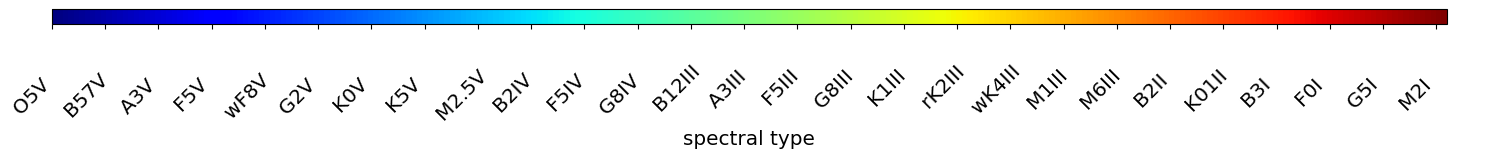

In [18]:
fig, ax = plt.subplots(figsize=(18, 0.2), layout='constrained')
cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=0, vmax=NSED)
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),cax=ax, orientation='horizontal', label='spectral type')

# change the number of labels
labels = [item.get_text() for item in cbar.ax.get_xticklabels()]
cbar.ax.locator_params(axis='x', nbins=4*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_xticklabels()]

# rename the labels
Nlabels = len(labels)
for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_pickle.loc[the_label,"SPTYPE"]
cbar.ax.set_xticklabels(labels,rotation=45);
plt.show()



/var/folders/79/hrybm_4s0zjd4jsb7lp_trhh0000gp/T/ipykernel_96231/2539020644.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.ax.set_yticklabels(labels,rotation=0);


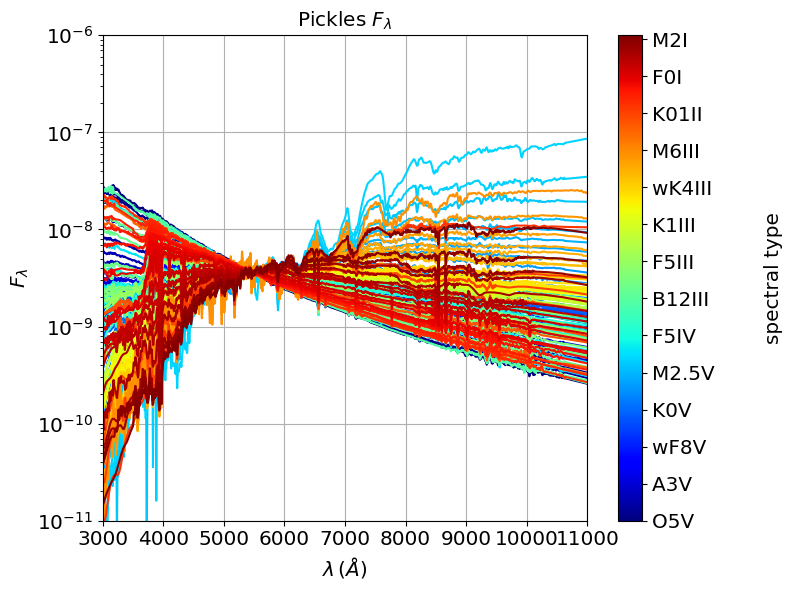

In [19]:
fig,ax = plt.subplots(1,1,figsize=(8,6))
for index in np.arange(NSED):
    filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
    fullfilename = os.path.join(seddir_uvk,filename) 
    hdul = fits.open(fullfilename)
    dff = pd.DataFrame(hdul[1].data)
    if index < 100 or index > 104: 
        ax.plot(dff.WAVELENGTH,dff.FLUX,color=all_colors[index])
ax.set_yscale('log')
ax.set_xlim(3000.,11000)
ax.set_ylim(1e-11,1e-6)
ax.grid()
ax.set_title("Pickles $F_\lambda$")
ax.set_ylabel("$F_\lambda$")
ax.set_xlabel("$\lambda \, (\AA$)")
#plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=0.8)
#ax.collections[-1].colorbar

cbar =fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),ax=ax, orientation='vertical', label='spectral type')

#cbar = plt.colorbar(ax.collections[0],ax=ax)
#cbar.ax.set_ylabel('spectral type', rotation=90)

labels = [item.get_text() for item in cbar.ax.get_yticklabels()]
cbar.ax.locator_params(axis='y', nbins=2*len(labels)) 
labels = [item.get_text() for item in cbar.ax.get_yticklabels()]

Nlabels = len(labels)
for ilab in range(0,Nlabels-1):
    the_label = int(labels[ilab])
    labels[ilab] = df_pickle.loc[the_label,"SPTYPE"]
cbar.ax.set_yticklabels(labels,rotation=0);
plt.tight_layout()


#### Convert Pickles SED in ubin_sim Photmat

In [32]:
all_sed = []
all_sed_type = []
all_sed_filename = []
zmag = 20.0
for index in np.arange(NSED):
    if index < 100 or index > 104: 
        spectype = df_pickle.loc[index,"SPTYPE"].strip()
        filename = df_pickle.loc[index,"FILENAME"].strip()+".fits"
        fullfilename = os.path.join(seddir_uvk,filename) 
        hdul = fits.open(fullfilename)
        dff = pd.DataFrame(hdul[1].data)
        wl= dff.WAVELENGTH.values
        flux = dff.FLUX.values
        #wavelen (nm)
        #flambda (ergs/cm^2/s/nm)
        the_sed = Sed(wavelen=wl/10., flambda=flux*10., name=spectype)
        flux_norm = the_sed.calc_flux_norm(zmag, pc.bandpass_total_std['r'])
        the_sed.multiply_flux_norm(flux_norm)
        all_sed.append(the_sed) 
        all_sed_type.append(spectype) 
        all_sed_filename.append(filename)
NSED = len(all_sed)

## Simulate multi atmospheres

In [24]:
am = 1.2
am1 = 1.0
am2 = 1.5
am3 = 2.0
oz = 300
tau= 0.04
beta = 1
all_pwv = np.arange(0,15.,0.5)
NPWV = len(all_pwv)

In [25]:
pc.CalculateMultiObs(am,all_pwv,oz,tau,beta)

/Users/dagoret/MacOSX/GitHub/LSST/AtmosphericSimulation/rubinsimphot/src/rubinsimphot/phot_utils/bandpass.py:68: UserWarning: Wavelength sampling of 1.0 nm is > 0.2 nm, this may not work well with a Sed object. Consider resampling with resample_bandpass method.
  warnings.warn(


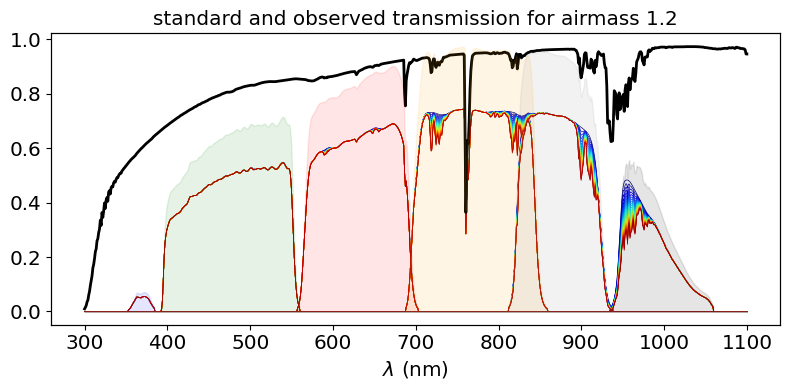

In [29]:
NOBS = len(all_pwv)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(8,4))

# Figure 1
axs=fig.add_subplot(1,1,1)
for index,pwv in enumerate(all_pwv):
  
    atm_bands = pc.coll_bandpass_total_nonstd[index]
  
    
    label = f"pwv={pwv:.1f}" 

    for f in filter_tagnames: 
        axs.plot(atm_bands[f].wavelen,atm_bands[f].sb,color=all_colors[index],label=label,lw=0.5)
  
   
axs.plot(pc.WL,pc.atm_std,color="k",lw=2,label="standard atmosphere")
#axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission for airmass 1.2")

ax2 = axs.twinx()
for ifilt,f in enumerate(filter_tagnames):
    ax2.fill_between(pc.bandpass_total_std[f].wavelen,pc.bandpass_total_std[f].sb,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])


plt.tight_layout()
plt.show()



In [31]:
#all_df_magcol = ComputeColors(pc,the_sed1,the_sed2)
#df_diffcol = ComputeRelativeDiffColor(all_df_magcol)
#z_y0 = df_diffcol.loc[0,"Czy1_Czy2_abmag"]

#dx = np.diff(df_diffcol.pwv.values).mean()
#dy1 = np.diff(df_diffcol["Czy1_Czy2_abmag_rel"].values)
#dy2 = np.diff(df_diffcol["Czy1_Czy2_instmag_rel"].values)